# A Totural on Binary Estimation 

In this notebook we are going to estimate weights (coefficients) of a linear regression model as binary values. Different scenarios with different methods such as least square, rounding, binary penalty term, and $L_1$ regularisation have been checked.

# Libraries

In [333]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_validate
from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import Lasso

# Data Generating

Dataset is generated over a normal distribution with $\mu=0$ and $\Sigma=\textit{I}_{p\times p}$ or
$X \sim \mathcal{N}_{p}(\mu, \Sigma)$.
The output is also generated based on a linear function including a noise term as follows 
\begin{align*}
Y&=X\beta^T+\epsilon \\
\epsilon &\sim \mathcal{N}(0, \sigma^2) \\
\end{align*}

And $\beta$ is the vector of weights.

In [334]:
def DataGenerator(n_samples, n_features, weights=None, noise_variance=1, feature_mean = None, feature_cov = None, random_state=None):
    RNG = np.random.default_rng(seed=random_state)

    if weights is None:
       weights = np.squeeze(RNG.multivariate_normal(np.zeros(1), 2*np.eye(1), size=n_features))
    else:
        weights = weights
    
    # n_features = len(weights)

    feature_mean = np.zeros(n_features) if feature_mean is None else feature_mean
    feature_cov = np.eye(n_features) if feature_cov is None else feature_cov
    x = RNG.multivariate_normal(feature_mean, feature_cov, size=n_samples)
    # x = np.hstack((np.ones(shape=(n_samples, 1)), x))

    y = x.dot(weights) + RNG.normal(0, noise_variance, size=n_samples)
    return x, y, weights

# Squared Error

To evaluate the performance of the applied methods we use the mean squared error with following definition

\begin{align*}
MSE&=\frac{1}{2N}\sum_{n=1}^{N}(\hat{y}_n-y_n)^2 \\
\end{align*}

In [335]:
def squared_error(beta, x, y, d=None): 
    d = x.shape[1]
    beta = np.reshape(beta,(-1, d))
    return np.sum((beta@x.T-y)**2)/(2*len(x))

# Least Square Estimation

In [336]:
def leastsquare(x, y):
    return np.linalg.solve(x.T.dot(x), x.T.dot(y))

# Optimizer

In [337]:
def minimizer(lossfunction, alpha, x, y, n_features=None):   
    n_features = x.shape[1]
    initial_beta = np.random.randint(2,size=(n_features))
    result = minimize(lossfunction, initial_beta, args=(alpha, x, y, n_features), method='Powell', options={'xtol':1e-8})
    optimized_beta = result.x
    return optimized_beta

# Sparsity: Binary Estimation

In [338]:
def binary_lossfunc(beta, alpha , x, y, n_features):
  pp = []
  beta = np.reshape(beta,(-1, n_features))
  for i in range((beta.shape)[0]):
    p = []
    for b in beta[i]:
      if b<=0.5:
        p.append(alpha*abs(b))
      else:
        p.append(alpha*abs(b-1))
    pp.append(np.sum(p))
  return squared_error(beta,x , y, n_features)+np.asarray(pp)

# Binary Rounding

In [339]:
def binary_round(v):
    v = np.asarray(v)
    bv = []
    for x in v:
        if abs(x) < abs(x-1):
            x = 0
        elif abs(x-1) < abs(x):
            x = 1
        else:
            x = x
        bv.append(x)
    return bv

# Resampling

In [340]:
class Resampling:

    def __init__(self, reps, train_size, random_state=None):
        self.reps = reps
        self.train_size = train_size
        self.RNG = np.random.default_rng(random_state)

    def get_n_splits(self):
        return self.reps

    def split(self, x, y=None, groups=None):
        for _ in range(self.reps):
            train_idx = self.RNG.choice(len(x), size=self.train_size, replace=True)
            test_idx = np.setdiff1d(np.arange(len(x)), train_idx)
            np.random.shuffle(test_idx)
            yield train_idx, test_idx

# Exhaustive Algorithm to find the best binary approximation

In [341]:
import itertools
def exhaustive_binary(n_answers, x, y):

    all_answer_lst = list(itertools.product([0, 1], repeat=n_answers))
    error = []
    for pa in all_answer_lst:
        error.append(squared_error(np.asarray(pa), x, y))

    error = np.asarray(error)
    best_binary = all_answer_lst[np.argmin(error)]
    return best_binary, np.min(error)

# CV algorithm to search for the best $\alpha$

In [342]:
def search_for_alph(x, y, func, alpha_range, sample_size, n_folds):
    func_mean_sse_valid_per_size = []
    func_min_valid_error_per_size, func_alpha_per_size = [], []

    if sample_size<n_folds:
        kf = KFold(n_splits=sample_size, shuffle=True, random_state=529)
    else:
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=529)

    func_mean_sse_valid_per_alpha,func_std_sse_valid_per_alpha = [], []

    for a in alpha_range:
        func_beta_hat_per_fold, func_rounded_beta_hat_per_fold, func_sse_train_per_fold, func_sse_valid_per_fold = [], [], [], []
        for train_ind, val_ind in kf.split(x,y):

            if func is Lasso:
                func_beta_hat_per_fold.append(Lasso(alpha=a).fit(x[train_ind], y[train_ind]).coef_)
            else:
                func_beta_hat_per_fold.append(minimizer(func, a, x[train_ind], y[train_ind], x.shape[1]))

            func_rounded_beta_hat_per_fold.append(binary_round(func_beta_hat_per_fold[-1]))
            # func_sse_train_per_fold.append(squared_error(func_rounded_beta_hat_per_fold[-1], x[train_ind], y[train_ind], x.shape[1]))
            func_sse_valid_per_fold.append(squared_error(func_rounded_beta_hat_per_fold[-1], x[val_ind], y[val_ind], x.shape[1]))

        func_mean_sse_valid_per_alpha.append(np.mean(func_sse_valid_per_fold))
        # func_std_sse_valid_per_alpha.append(np.std(func_sse_valid_per_fold))
    
    func_min_valid_error_per_size = min(func_mean_sse_valid_per_alpha)
    func_alpha_per_size = alpha_range[func_mean_sse_valid_per_alpha.index(min(func_mean_sse_valid_per_alpha))]
    func_mean_sse_valid_per_size = func_mean_sse_valid_per_alpha

    return func_alpha_per_size, func_min_valid_error_per_size, func_mean_sse_valid_per_size


# Scenario No. 1: A dataset with binary weights

In the first scenario a dataset with $n_{features}=10$ features and $n_{samples}$ sample has been considered. $\beta$ is a vector of 0 and 1: $\beta_i \sim \{1,0\}, \beta = \{\beta_i | i=1,..,n_{features}\}$

In [343]:
beta = np.array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1])
xb,yb, _ = DataGenerator(n_samples=50, n_features=len(beta), weights=beta, random_state=123)
xb_test, yb_test, _ = DataGenerator(n_samples=1000, n_features=len(beta), weights=beta, random_state=1)

In [344]:
alpha_range = np.logspace(-3, 0, num=10)
n_folds = 25
n_iterations = 200
sample_size = np.round(100*np.array(np.linspace(0.15,0.4,10))).astype(int)
l1_min_alpha_per_size, l1_min_sse_valid_per_size, l1_mean_sse_valid_per_size = [], [], []
binary_min_alpha_per_size, binary_min_sse_valid_per_size, binary_mean_sse_valid_per_size = [], [], []
l1_train_mean_sse_per_size, l1_train_std_sse_per_size, l1_test_mean_sse_per_size, l1_test_std_sse_per_size = [], [], [], []
binary_train_mean_sse_per_size, binary_train_std_sse_per_size, binary_test_mean_sse_per_size, binary_test_std_sse_per_size = [], [], [], []
l1_beta_hat_mean_error_per_size,l1_beta_hat_std_error_per_size, binary_beta_hat_mean_error_per_size, binary_beta_hat_std_error_per_size = [], [], [], []
ls_train_mean_sse_per_size, ls_train_std_sse_per_size, ls_test_mean_sse_per_size, ls_test_std_sse_per_size, ls_beta_hat_mean_error_per_size, ls_beta_hat_std_error_per_size = [], [], [], [], [], []
rls_train_mean_sse_per_size, rls_train_std_sse_per_size, rls_test_mean_sse_per_size, rls_test_std_sse_per_size, rls_beta_hat_mean_error_per_size, rls_beta_hat_std_error_per_size = [], [], [], [], [], []
best_binary_mean_train_sse_per_size,best_binary_std_train_sse_per_size, best_binary_beta_hat_mean_error_per_size, best_binary_beta_hat_std_error_per_size = [], [], [], []

In [345]:
for ss in sample_size:

    # estimating the best alpha
    xb_selected, yb_selected, _ = DataGenerator(n_samples=ss, n_features=len(beta), weights=beta, random_state=123)
    l1_min_alpha, l1_min_sse_valid, l1_mean_sse_valid = search_for_alph(xb_selected, yb_selected, Lasso, alpha_range, ss, n_folds)
    l1_min_alpha_per_size.append(l1_min_alpha)
    l1_min_sse_valid_per_size.append(l1_min_sse_valid)
    l1_mean_sse_valid_per_size.append(l1_mean_sse_valid)

    binary_min_alpha, binary_min_sse_valid, binary_mean_sse_valid = search_for_alph(xb_selected, yb_selected, binary_lossfunc, alpha_range, ss, n_folds)
    binary_min_alpha_per_size.append(binary_min_alpha)
    binary_min_sse_valid_per_size.append(binary_min_sse_valid)
    binary_mean_sse_valid_per_size.append(binary_mean_sse_valid)

    # estimating the beta in iterations
    l1_beta_hat_per_iter, l1_rounded_beta_hat_per_iter, l1_train_sse_per_iter, l1_test_sse_per_iter = [], [], [], []
    binary_beta_hat_per_iter, binary_rounded_beta_hat_per_iter, binary_train_sse_per_iter, binary_test_sse_per_iter = [], [], [], []
    ls_beta_hat_per_iter, ls_train_sse_per_iter, ls_test_sse_per_iter = [], [], []
    rls_beta_hat_per_iter,rls_train_sse_per_iter,rls_test_sse_per_iter = [], [], []
    best_binary_train_sse_per_iter, best_binary_beta_hat_per_iter = [], []
    for iter in range(n_iterations):

        xb_selected, yb_selected, _ = DataGenerator(n_samples=ss, n_features=len(beta), weights=beta, random_state=None)

        l1_beta_hat_per_iter.append(Lasso(l1_min_alpha).fit(xb_selected, yb_selected).coef_)
        l1_rounded_beta_hat_per_iter.append(binary_round(l1_beta_hat_per_iter[-1]))
        l1_train_sse_per_iter.append(squared_error(binary_round(l1_beta_hat_per_iter[-1]),xb_selected, yb_selected))
        l1_test_sse_per_iter.append(squared_error(binary_round(l1_beta_hat_per_iter[-1]),xb_test, yb_test))

        binary_beta_hat_per_iter.append(minimizer(binary_lossfunc, alpha=binary_min_alpha, x=xb_selected, y=yb_selected))
        binary_rounded_beta_hat_per_iter.append(binary_round(binary_beta_hat_per_iter[-1]))
        binary_train_sse_per_iter.append(squared_error(binary_round(binary_beta_hat_per_iter[-1]),xb_selected, yb_selected))
        binary_test_sse_per_iter.append(squared_error(binary_round(binary_beta_hat_per_iter[-1]),xb_test, yb_test))

        ls_beta_hat_per_iter.append(leastsquare(xb_selected, yb_selected))
        ls_train_sse_per_iter.append(squared_error(ls_beta_hat_per_iter[-1], xb_selected, yb_selected))
        ls_test_sse_per_iter.append(squared_error(ls_beta_hat_per_iter[-1], xb_test, yb_test))

        rls_beta_hat_per_iter.append(binary_round(ls_beta_hat_per_iter[-1]))
        rls_train_sse_per_iter.append(squared_error(rls_beta_hat_per_iter[-1], xb_selected, yb_selected))
        rls_test_sse_per_iter.append(squared_error(rls_beta_hat_per_iter[-1], xb_test, yb_test))

        best_binary_answer, best_binary_train_error = exhaustive_binary(n_answers=10, x=xb_selected, y=yb_selected)
        best_binary_train_sse_per_iter.append(best_binary_train_error)
        best_binary_beta_hat_per_iter.append(best_binary_answer)

    l1_train_mean_sse_per_size.append(np.mean(l1_train_sse_per_iter))
    l1_train_std_sse_per_size.append(np.std(l1_train_sse_per_iter))
    l1_test_mean_sse_per_size.append(np.mean(l1_test_sse_per_iter))
    l1_test_std_sse_per_size.append(np.std(l1_test_sse_per_iter))
    l1_beta_hat_mean_error_per_size.append(np.mean(np.sum((beta-l1_rounded_beta_hat_per_iter)**2, axis=1)))
    l1_beta_hat_std_error_per_size.append(np.std(np.sum((beta-l1_rounded_beta_hat_per_iter)**2, axis=1)))

    binary_train_mean_sse_per_size.append(np.mean(binary_train_sse_per_iter))
    binary_train_std_sse_per_size.append(np.std(binary_train_sse_per_iter))
    binary_test_mean_sse_per_size.append(np.mean(binary_test_sse_per_iter))
    binary_test_std_sse_per_size.append(np.std(binary_test_sse_per_iter))
    binary_beta_hat_mean_error_per_size.append(np.mean(np.sum((beta-binary_rounded_beta_hat_per_iter)**2, axis=1)))
    binary_beta_hat_std_error_per_size.append(np.std(np.sum((beta-binary_rounded_beta_hat_per_iter)**2, axis=1)))

    ls_train_mean_sse_per_size.append(np.mean(ls_train_sse_per_iter))
    ls_train_std_sse_per_size.append(np.std(ls_train_sse_per_iter))
    ls_test_mean_sse_per_size.append(np.mean(ls_test_sse_per_iter))
    ls_test_std_sse_per_size.append(np.std(ls_test_sse_per_iter))
    ls_beta_hat_mean_error_per_size.append(np.mean(np.sum((beta-ls_beta_hat_per_iter)**2, axis=1)))
    ls_beta_hat_std_error_per_size.append(np.std(np.sum((beta-ls_beta_hat_per_iter)**2, axis=1)))

    rls_train_mean_sse_per_size.append(np.mean(rls_train_sse_per_iter))
    rls_train_std_sse_per_size.append(np.std(rls_train_sse_per_iter))
    rls_test_mean_sse_per_size.append(np.mean(rls_test_sse_per_iter))
    rls_test_std_sse_per_size.append(np.std(rls_test_sse_per_iter))
    rls_beta_hat_mean_error_per_size.append(np.mean(np.sum((beta-rls_beta_hat_per_iter)**2, axis=1)))
    rls_beta_hat_std_error_per_size.append(np.std(np.sum((beta-rls_beta_hat_per_iter)**2, axis=1)))

    best_binary_mean_train_sse_per_size.append(np.mean(best_binary_train_sse_per_iter))
    best_binary_std_train_sse_per_size.append(np.std(best_binary_train_sse_per_iter))
    best_binary_beta_hat_mean_error_per_size.append(np.mean(np.sum((beta-best_binary_beta_hat_per_iter)**2, axis=1)))
    best_binary_beta_hat_std_error_per_size.append(np.std(np.sum((beta-best_binary_beta_hat_per_iter)**2, axis=1)))

best_binary_beta_hat_test, best_binary_sse_test = exhaustive_binary(n_answers=10, x=xb_test, y=yb_test)

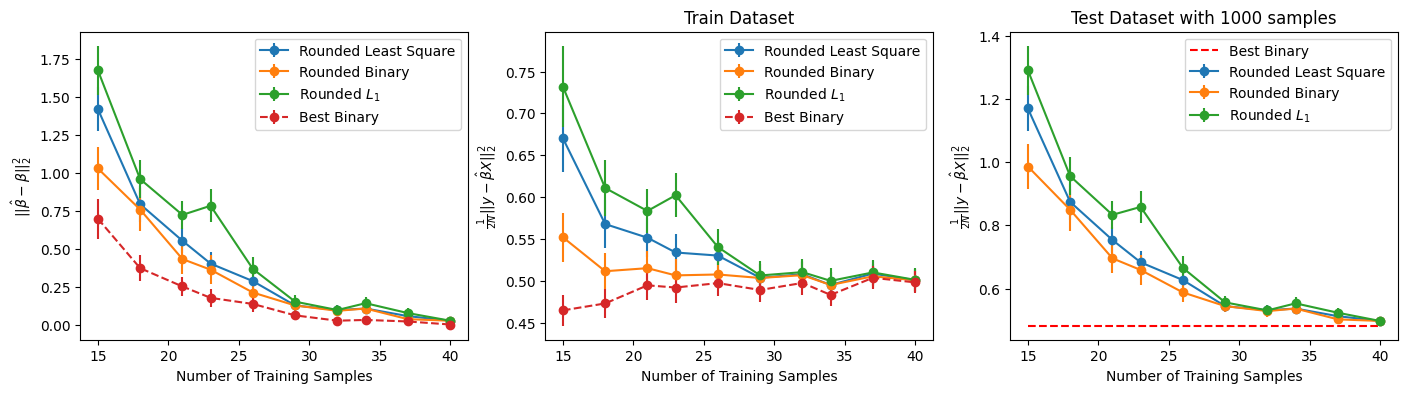

In [378]:
_, axs = plt.subplots(1, 3, figsize=(17, 4))
axs[0].errorbar(sample_size, rls_beta_hat_mean_error_per_size, yerr=np.array(rls_beta_hat_std_error_per_size)*1.96/(n_iterations**0.5), marker='o',  label='Rounded Least Square')
axs[0].errorbar(sample_size, binary_beta_hat_mean_error_per_size, yerr=np.array(binary_beta_hat_std_error_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Binary')
axs[0].errorbar(sample_size, l1_beta_hat_mean_error_per_size, yerr=np.array(l1_beta_hat_std_error_per_size)*1.96/(n_iterations**0.5), marker='o',  label='Rounded $L_1$')
axs[0].errorbar(sample_size, best_binary_beta_hat_mean_error_per_size, yerr=np.array(best_binary_beta_hat_std_error_per_size)*1.96/(n_iterations**0.5), linestyle='--',marker='o',  label='Best Binary')
# axs[0].errorbar(sample_size, ls_beta_hat_mean_error_per_size, yerr=np.array(ls_beta_hat_std_error_per_size)*1.96/(n_iterations**0.5), marker='o', label='Least Square')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('$||\\hat{\\beta}-\\beta||_{2}^{2}$')
axs[0].legend()

axs[1].errorbar(sample_size, rls_train_mean_sse_per_size, yerr=np.array(rls_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, binary_train_mean_sse_per_size, yerr=np.array(binary_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Binary')
axs[1].errorbar(sample_size, l1_train_mean_sse_per_size, yerr=np.array(l1_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o',  label='Rounded $L_1$')
axs[1].errorbar(sample_size, best_binary_mean_train_sse_per_size, yerr=np.array(best_binary_std_train_sse_per_size)*1.96/(n_iterations**0.5), linestyle='--', marker='o', label='Best Binary')
# axs[1].errorbar(sample_size, ls_train_mean_sse_per_size, yerr=np.array(ls_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o',  label='Least Square')
axs[1].set_xlabel('Number of Training Samples')
axs[1].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[1].set_title(f'Train Dataset')
axs[1].legend()

axs[2].errorbar(sample_size, rls_test_mean_sse_per_size, yerr=np.array(rls_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Least Square')
axs[2].errorbar(sample_size, binary_test_mean_sse_per_size, yerr=np.array(binary_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Binary')
axs[2].errorbar(sample_size, l1_test_mean_sse_per_size, yerr=np.array(l1_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded $L_1$')
# axs[2].errorbar(sample_size, ls_test_mean_sse_per_size, yerr=np.array(ls_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o',  label='Least Square')
axs[2].hlines(best_binary_sse_test, min(sample_size), max(sample_size), linestyle='--', color='red', label='Best Binary')
axs[2].set_xlabel('Number of Training Samples')
axs[2].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[2].set_title(f'Test Dataset with 1000 samples')
axs[2].legend()

# Scenario No. 2: A dataset with non-binary weights (Rounded Least Square vs. Rounded Binary Penalty)

In this scenario, the database is generated same as before with $n_{features}=10$ but $\beta$ is a vector of non-binary values from $\beta \sim \mathcal{N}(\mu_2=0, \sigma_2^2=2)$. Now we are going to find the best binary approximation for $\beta$ that minimizes the loss function.

In [347]:
xnb, ynb, beta_nb = DataGenerator(n_samples=100, n_features=10, random_state=123)
xnb_test, ynb_test, _ = DataGenerator(n_samples=1000, weights=beta_nb, n_features=10, random_state=123)

First of all we try to find all the possible binary answers by an exhaustive algorithm.

In [348]:
alpha_range = np.logspace(-3, 0, num=10)
n_folds = 25
n_iterations = 500
# sample_size = np.round(100*np.array(np.linspace(0.2,1,25))).astype(int)
nb_l1_min_alpha_per_size, nb_l1_min_sse_valid_per_size, nb_l1_mean_sse_valid_per_size = [], [], []
nb_binary_min_alpha_per_size, nb_binary_min_sse_valid_per_size, nb_binary_mean_sse_valid_per_size = [], [], []
nb_l1_train_mean_sse_per_size, nb_l1_train_std_sse_per_size, nb_l1_test_mean_sse_per_size, nb_l1_test_std_sse_per_size = [], [], [], []
nb_binary_train_mean_sse_per_size, nb_binary_train_std_sse_per_size, nb_binary_test_mean_sse_per_size, nb_binary_test_std_sse_per_size = [], [], [], []
nb_l1_beta_hat_mean_error_per_size,nb_l1_beta_hat_std_error_per_size, nb_binary_beta_hat_mean_error_per_size, nb_binary_beta_hat_std_error_per_size = [], [], [], []
nb_ls_train_mean_sse_per_size, nb_ls_train_std_sse_per_size, nb_ls_test_mean_sse_per_size, nb_ls_test_std_sse_per_size, nb_ls_beta_hat_mean_error_per_size, nb_ls_beta_hat_std_error_per_size = [], [], [], [], [], []
nb_rls_train_mean_sse_per_size, nb_rls_train_std_sse_per_size, nb_rls_test_mean_sse_per_size, nb_rls_test_std_sse_per_size, nb_rls_beta_hat_mean_error_per_size, nb_rls_beta_hat_std_error_per_size = [], [], [], [], [], []
nb_best_binary_mean_train_sse_per_size,nb_best_binary_std_train_sse_per_size, nb_best_binary_beta_hat_mean_error_per_size, nb_best_binary_beta_hat_std_error_per_size = [], [], [], []

In [349]:
for ss in sample_size:

    # estimating the best alpha
    xnb_selected, ynb_selected, _ = DataGenerator(n_samples=ss, n_features=len(beta_nb), weights=beta_nb, random_state=123)
    nb_l1_min_alpha, nb_l1_min_sse_valid, nb_l1_mean_sse_valid = search_for_alph(xnb_selected, ynb_selected, Lasso, alpha_range, ss, n_folds)
    nb_l1_min_alpha_per_size.append(nb_l1_min_alpha)
    nb_l1_min_sse_valid_per_size.append(nb_l1_min_sse_valid)
    nb_l1_mean_sse_valid_per_size.append(nb_l1_mean_sse_valid)

    nb_binary_min_alpha, nb_binary_min_sse_valid, nb_binary_mean_sse_valid = search_for_alph(xnb_selected, ynb_selected, binary_lossfunc, alpha_range, ss, n_folds)
    nb_binary_min_alpha_per_size.append(nb_binary_min_alpha)
    nb_binary_min_sse_valid_per_size.append(nb_binary_min_sse_valid)
    nb_binary_mean_sse_valid_per_size.append(nb_binary_mean_sse_valid)

    # estimating the beta in iterations
    nb_l1_beta_hat_per_iter, nb_l1_rounded_beta_hat_per_iter, nb_l1_train_sse_per_iter, nb_l1_test_sse_per_iter = [], [], [], []
    nb_binary_beta_hat_per_iter, nb_binary_rounded_beta_hat_per_iter, nb_binary_train_sse_per_iter, nb_binary_test_sse_per_iter = [], [], [], []
    nb_ls_beta_hat_per_iter, nb_ls_train_sse_per_iter, nb_ls_test_sse_per_iter = [], [], []
    nb_rls_beta_hat_per_iter,nb_rls_train_sse_per_iter,nb_rls_test_sse_per_iter = [], [], []
    nb_best_binary_train_sse_per_iter, nb_best_binary_beta_hat_per_iter = [], []
    for iter in range(n_iterations):

        xnb_selected, ynb_selected, _ = DataGenerator(n_samples=ss, n_features=len(beta_nb), weights=beta_nb, random_state=None)

        nb_l1_beta_hat_per_iter.append(Lasso(nb_l1_min_alpha).fit(xnb_selected, ynb_selected).coef_)
        nb_l1_rounded_beta_hat_per_iter.append(binary_round(nb_l1_beta_hat_per_iter[-1]))
        nb_l1_train_sse_per_iter.append(squared_error(binary_round(nb_l1_beta_hat_per_iter[-1]),xnb_selected, ynb_selected))
        nb_l1_test_sse_per_iter.append(squared_error(binary_round(nb_l1_beta_hat_per_iter[-1]),xnb_test, ynb_test))

        nb_binary_beta_hat_per_iter.append(minimizer(binary_lossfunc, alpha=nb_binary_min_alpha, x=xnb_selected, y=ynb_selected))
        nb_binary_rounded_beta_hat_per_iter.append(binary_round(nb_binary_beta_hat_per_iter[-1]))
        nb_binary_train_sse_per_iter.append(squared_error(binary_round(nb_binary_beta_hat_per_iter[-1]),xnb_selected, ynb_selected))
        nb_binary_test_sse_per_iter.append(squared_error(binary_round(nb_binary_beta_hat_per_iter[-1]),xnb_test, ynb_test))

        nb_ls_beta_hat_per_iter.append(leastsquare(xnb_selected, ynb_selected))
        nb_ls_train_sse_per_iter.append(squared_error(nb_ls_beta_hat_per_iter[-1], xnb_selected, ynb_selected))
        nb_ls_test_sse_per_iter.append(squared_error(nb_ls_beta_hat_per_iter[-1], xnb_test, ynb_test))

        nb_rls_beta_hat_per_iter.append(binary_round(nb_ls_beta_hat_per_iter[-1]))
        nb_rls_train_sse_per_iter.append(squared_error(nb_rls_beta_hat_per_iter[-1], xnb_selected, ynb_selected))
        nb_rls_test_sse_per_iter.append(squared_error(nb_rls_beta_hat_per_iter[-1], xnb_test, ynb_test))

        nb_best_binary_answer, nb_best_binary_train_error = exhaustive_binary(n_answers=10, x=xnb_selected, y=ynb_selected)
        nb_best_binary_train_sse_per_iter.append(nb_best_binary_train_error)
        # nb_best_binary_beta_hat_per_iter.append(nb_best_binary_answer)

    nb_l1_train_mean_sse_per_size.append(np.mean(nb_l1_train_sse_per_iter))
    nb_l1_train_std_sse_per_size.append(np.std(nb_l1_train_sse_per_iter))
    nb_l1_test_mean_sse_per_size.append(np.mean(nb_l1_test_sse_per_iter))
    nb_l1_test_std_sse_per_size.append(np.std(nb_l1_test_sse_per_iter))
    # nb_l1_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_binary_nb-nb_l1_rounded_beta_hat_per_iter)**2, axis=1)))
    # nb_l1_beta_hat_std_error_per_size.append(np.std(np.sum((best_binary_nb-nb_l1_rounded_beta_hat_per_iter)**2, axis=1)))

    nb_binary_train_mean_sse_per_size.append(np.mean(nb_binary_train_sse_per_iter))
    nb_binary_train_std_sse_per_size.append(np.std(nb_binary_train_sse_per_iter))
    nb_binary_test_mean_sse_per_size.append(np.mean(nb_binary_test_sse_per_iter))
    nb_binary_test_std_sse_per_size.append(np.std(nb_binary_test_sse_per_iter))
    # nb_binary_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_binary_nb-nb_binary_rounded_beta_hat_per_iter)**2, axis=1)))
    # nb_binary_beta_hat_std_error_per_size.append(np.std(np.sum((best_binary_nb-nb_binary_rounded_beta_hat_per_iter)**2, axis=1)))

    nb_ls_train_mean_sse_per_size.append(np.mean(nb_ls_train_sse_per_iter))
    nb_ls_train_std_sse_per_size.append(np.std(nb_ls_train_sse_per_iter))
    nb_ls_test_mean_sse_per_size.append(np.mean(nb_ls_test_sse_per_iter))
    nb_ls_test_std_sse_per_size.append(np.std(nb_ls_test_sse_per_iter))
    # nb_ls_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_binary_nb-nb_ls_beta_hat_per_iter)**2, axis=1)))
    # nb_ls_beta_hat_std_error_per_size.append(np.std(np.sum((best_binary_nb-nb_ls_beta_hat_per_iter)**2, axis=1)))

    nb_rls_train_mean_sse_per_size.append(np.mean(nb_rls_train_sse_per_iter))
    nb_rls_train_std_sse_per_size.append(np.std(nb_rls_train_sse_per_iter))
    nb_rls_test_mean_sse_per_size.append(np.mean(nb_rls_test_sse_per_iter))
    nb_rls_test_std_sse_per_size.append(np.std(nb_rls_test_sse_per_iter))
    # nb_rls_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_binary_nb-nb_rls_beta_hat_per_iter)**2, axis=1)))
    # nb_rls_beta_hat_std_error_per_size.append(np.std(np.sum((best_binary_nb-nb_rls_beta_hat_per_iter)**2, axis=1)))

    nb_best_binary_mean_train_sse_per_size.append(np.mean(nb_best_binary_train_sse_per_iter))
    nb_best_binary_std_train_sse_per_size.append(np.std(nb_best_binary_train_sse_per_iter))

nb_best_binary_beta_hat_test, nb_best_binary_sse_test = exhaustive_binary(n_answers=10, x=xnb_test, y=ynb_test)
    

In [350]:
# _, axs = plt.subplots(5, 5, figsize=(25, 25))
# ss=0
# for row in range(5):
#     for col in range(5):
#         axs[row][col].plot(alpha_range, nb_binary_mean_sse_valid_per_size[ss], label='Binary')
#         axs[row][col].plot(alpha_range, nb_l1_mean_sse_valid_per_size[ss], label='$L_1$')
#         axs[row][col].legend()
#         axs[row][col].set_xlabel('$\\alpha$')
#         axs[row][col].set_ylabel('Test Error')
#         axs[row][col].set_title(f'Sample Size is {sample_size[ss]}')
#         ss = ss + 1

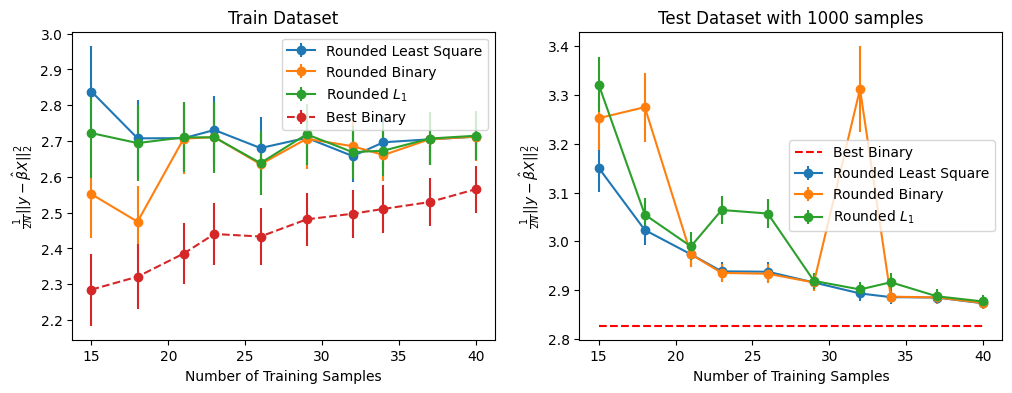

In [377]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].errorbar(sample_size, nb_rls_train_mean_sse_per_size, yerr=np.array(nb_rls_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Least Square')
axs[0].errorbar(sample_size, nb_binary_train_mean_sse_per_size, yerr=np.array(nb_binary_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Binary')
axs[0].errorbar(sample_size, nb_l1_train_mean_sse_per_size, yerr=np.array(nb_l1_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o',  label='Rounded $L_1$')
# axs[0].errorbar(sample_size, nb_ls_train_mean_sse_per_size, yerr=np.array(nb_ls_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o',  label='Least Square')
axs[0].errorbar(sample_size, nb_best_binary_mean_train_sse_per_size, yerr=np.array(nb_best_binary_std_train_sse_per_size)*1.96/(n_iterations**0.5), linestyle='--', marker='o', label='Best Binary')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[0].set_title(f'Train Dataset')
axs[0].legend()

axs[1].errorbar(sample_size, nb_rls_test_mean_sse_per_size, yerr=np.array(nb_rls_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, nb_binary_test_mean_sse_per_size, yerr=np.array(nb_binary_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Binary')
axs[1].errorbar(sample_size, nb_l1_test_mean_sse_per_size, yerr=np.array(nb_l1_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded $L_1$')
# axs[1].errorbar(sample_size, nb_ls_test_mean_sse_per_size, yerr=np.array(nb_ls_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o',  label='Least Square')
axs[1].hlines(nb_best_binary_sse_test, min(sample_size), max(sample_size), linestyle='--',color='red', label='Best Binary')
axs[1].set_xlabel('Number of Training Samples')
axs[1].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[1].set_title(f'Test Dataset with 1000 samples')
axs[1].legend()

# Scenario No. 3

In this scenario the weights vector is considered as $\beta = [0.5, 0.5, 0]$. Also the features are not independent from each other and thery are defined as follows

\begin{align*}
y&= 0.5x_1 + 0.5x_2 + x_3 + \epsilon_1 \\
x_3&=0.5x_1 + 0.5x_2 + \epsilon_2 \\
\epsilon_1 &\sim \mathcal{N}(0, \sigma_1^2) \\
\epsilon_2 &\sim \mathcal{N}(0, \sigma_2^2) 
\end{align*}

We can rewrite this linear function in two ways

\begin{align*}
1: y&= x_1 + x_2 + \epsilon_1 + \epsilon_2 \to \beta = [1,1,0]\\ 
2: y&= x_3 + \epsilon_1 - \epsilon_2 \to \beta = [0,0,1]
\end{align*}

In [392]:
def DataGenerator_x123(n_samples,feature_mean, feature_cov, sigma1, sigma2, randome_state=None):
    RNG = np.random.default_rng(seed=randome_state)
    beta3 = np.array([0.5, 0.5])
    beta = np.array([0.5, 0.5, 1])
    # feature_mean = np.zeros(2)
    # feature_cov = 2*np.eye(2)
    # sigma1 = 0.5
    # sigma2 = 0.5
    x12 = RNG.multivariate_normal(feature_mean, feature_cov, size=n_samples)
    x3 = (x12.dot(beta3) + RNG.normal(0, sigma2, size=n_samples)).reshape(-1,1)
    x = np.hstack((x12, x3))
    y = x.dot(beta) + RNG.normal(0, sigma1, size=n_samples)
    return x, y

In [393]:
x_test, y_test = DataGenerator_x123(n_samples=10000, feature_mean=np.zeros(2), feature_cov=2*np.eye(2), sigma1=0.5, sigma2=0.5, randome_state=123)

In [394]:
# alpha_range = [0.001, 0.1, 0.5, 1, 1.5, 2, 3]
alpha_range = np.logspace(-3, 0, num=10)
n_folds = 25
n_iterations = 300
# sample_size = np.round(100*np.array(np.linspace(0.2,1,25))).astype(int)
x123_l1_train_mean_sse_per_size,x123_l1_train_std_sse_per_size, x123_l1_test_mean_sse_per_size, x123_l1_test_std_sse_per_size = [], [], [], []
x123_l1_min_alpha_per_size,x123_l1_min_sse_valid_per_size,x123_l1_mean_sse_valid_per_size = [], [], []
x123_binary_min_alpha_per_size, x123_binary_min_sse_valid_per_size, x123_binary_mean_sse_valid_per_size = [], [], []
x123_binary_train_mean_sse_per_size, x123_binary_train_std_sse_per_size, x123_binary_test_mean_sse_per_size, x123_binary_test_std_sse_per_size = [], [], [], []
x123_ls_train_mean_sse_per_size, x123_ls_train_std_sse_per_size, x123_ls_test_mean_sse_per_size, x123_ls_test_std_sse_per_size, x123_ls_beta_hat_mean_error_per_size, x123_ls_beta_hat_std_error_per_size = [], [], [], [], [], []
x123_rls_train_mean_sse_per_size, x123_rls_train_std_sse_per_size, x123_rls_test_mean_sse_per_size, x123_rls_test_std_sse_per_size, x123_rls_beta_hat_mean_error_per_size, x123_rls_beta_hat_std_error_per_size = [], [], [], [], [], []
x123_best_binary_mean_train_sse_per_size,x123_best_binary_std_train_sse_per_size, x123_best_binary_beta_hat_mean_error_per_size, x123_best_binary_beta_hat_std_error_per_size = [], [], [], []

In [355]:
for ss in sample_size:

    # estimating the best alpha
    x_selected, y_selected = DataGenerator_x123(n_samples=ss, feature_mean=np.zeros(2), feature_cov=2*np.eye(2), sigma1=0.5, sigma2=0.5, randome_state=123)
    x123_l1_min_alpha, x123_l1_min_sse_valid, x123_l1_mean_sse_valid = search_for_alph(x_selected, y_selected, Lasso, alpha_range, ss, n_folds)
    x123_l1_min_alpha_per_size.append(x123_l1_min_alpha)
    x123_l1_min_sse_valid_per_size.append(x123_l1_min_sse_valid)
    x123_l1_mean_sse_valid_per_size.append(x123_l1_mean_sse_valid)

    x123_binary_min_alpha, x123_binary_min_sse_valid, x123_binary_mean_sse_valid = search_for_alph(x_selected, y_selected, binary_lossfunc, alpha_range, ss, n_folds)
    x123_binary_min_alpha_per_size.append(x123_binary_min_alpha)
    x123_binary_min_sse_valid_per_size.append(x123_binary_min_sse_valid)
    x123_binary_mean_sse_valid_per_size.append(x123_binary_mean_sse_valid)

    # estimating the beta in iterations
    x123_l1_beta_hat_per_iter, x123_l1_rounded_beta_hat_per_iter, x123_l1_train_sse_per_iter, x123_l1_test_sse_per_iter = [], [], [], []
    x123_binary_beta_hat_per_iter, x123_binary_rounded_beta_hat_per_iter, x123_binary_train_sse_per_iter, x123_binary_test_sse_per_iter = [], [], [], []
    x123_ls_beta_hat_per_iter, x123_ls_train_sse_per_iter, x123_ls_test_sse_per_iter = [], [], []
    x123_rls_beta_hat_per_iter,x123_rls_train_sse_per_iter,x123_rls_test_sse_per_iter = [], [], []
    x123_best_binary_train_sse_per_iter, x123_best_binary_beta_hat_per_iter = [], []
    for iter in range(n_iterations):

        x_selected, y_selected = DataGenerator_x123(n_samples=ss, feature_mean=np.zeros(2), feature_cov=2*np.eye(2), sigma1=0.5, sigma2=0.5, randome_state=None)

        x123_l1_beta_hat_per_iter.append(Lasso(x123_l1_min_alpha).fit(x_selected, y_selected).coef_)
        x123_l1_rounded_beta_hat_per_iter.append(binary_round(x123_l1_beta_hat_per_iter[-1]))
        x123_l1_train_sse_per_iter.append(squared_error(binary_round(x123_l1_beta_hat_per_iter[-1]),x_selected, y_selected))
        x123_l1_test_sse_per_iter.append(squared_error(binary_round(x123_l1_beta_hat_per_iter[-1]),x_test, y_test))

        x123_binary_beta_hat_per_iter.append(minimizer(binary_lossfunc, alpha=x123_binary_min_alpha, x=x_selected, y=y_selected))
        x123_binary_rounded_beta_hat_per_iter.append(binary_round(x123_binary_beta_hat_per_iter[-1]))
        x123_binary_train_sse_per_iter.append(squared_error(binary_round(x123_binary_beta_hat_per_iter[-1]),x_selected, y_selected))
        x123_binary_test_sse_per_iter.append(squared_error(binary_round(x123_binary_beta_hat_per_iter[-1]),x_test, y_test))

        x123_ls_beta_hat_per_iter.append(leastsquare(x_selected, y_selected))
        x123_ls_train_sse_per_iter.append(squared_error(x123_ls_beta_hat_per_iter[-1], x_selected, y_selected))
        x123_ls_test_sse_per_iter.append(squared_error(x123_ls_beta_hat_per_iter[-1], x_test, y_test))

        x123_rls_beta_hat_per_iter.append(binary_round(x123_ls_beta_hat_per_iter[-1]))
        x123_rls_train_sse_per_iter.append(squared_error(x123_rls_beta_hat_per_iter[-1], x_selected, y_selected))
        x123_rls_test_sse_per_iter.append(squared_error(x123_rls_beta_hat_per_iter[-1], x_test, y_test))

        x123_best_binary_answer, x123_best_binary_train_error = exhaustive_binary(n_answers=3, x=x_selected, y=y_selected)
        x123_best_binary_train_sse_per_iter.append(x123_best_binary_train_error)
        # nb_best_binary_beta_hat_per_iter.append(nb_best_binary_answer)

    x123_l1_train_mean_sse_per_size.append(np.mean(x123_l1_train_sse_per_iter))
    x123_l1_train_std_sse_per_size.append(np.std(x123_l1_train_sse_per_iter))
    x123_l1_test_mean_sse_per_size.append(np.mean(x123_l1_test_sse_per_iter))
    x123_l1_test_std_sse_per_size.append(np.std(x123_l1_test_sse_per_iter))
    # x123_l1_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_binary_nb-nb_l1_rounded_beta_hat_per_iter)**2, axis=1)))
    # x123_l1_beta_hat_std_error_per_size.append(np.std(np.sum((best_binary_nb-nb_l1_rounded_beta_hat_per_iter)**2, axis=1)))

    x123_binary_train_mean_sse_per_size.append(np.mean(x123_binary_train_sse_per_iter))
    x123_binary_train_std_sse_per_size.append(np.std(x123_binary_train_sse_per_iter))
    x123_binary_test_mean_sse_per_size.append(np.mean(x123_binary_test_sse_per_iter))
    x123_binary_test_std_sse_per_size.append(np.std(x123_binary_test_sse_per_iter))
    # x123_binary_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_possible[0]-x123_binary_rounded_beta_hat_per_iter)**2, axis=1)))
    # x123_binary_beta_hat_std_error_per_size.append(np.std(np.sum((best_possible[0]-x123_binary_rounded_beta_hat_per_iter)**2, axis=1)))

    x123_ls_train_mean_sse_per_size.append(np.mean(x123_ls_train_sse_per_iter))
    x123_ls_train_std_sse_per_size.append(np.std(x123_ls_train_sse_per_iter))
    x123_ls_test_mean_sse_per_size.append(np.mean(x123_ls_test_sse_per_iter))
    x123_ls_test_std_sse_per_size.append(np.std(x123_ls_test_sse_per_iter))
    # x123_ls_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_possible[0]-x123_ls_beta_hat_per_iter)**2, axis=1)))
    # x123_ls_beta_hat_std_error_per_size.append(np.std(np.sum((best_possible[0]-x123_ls_beta_hat_per_iter)**2, axis=1)))

    x123_rls_train_mean_sse_per_size.append(np.mean(x123_rls_train_sse_per_iter))
    x123_rls_train_std_sse_per_size.append(np.std(x123_rls_train_sse_per_iter))
    x123_rls_test_mean_sse_per_size.append(np.mean(x123_rls_test_sse_per_iter))
    x123_rls_test_std_sse_per_size.append(np.std(x123_rls_test_sse_per_iter))
    # x123_rls_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_possible[0]-x123_rls_beta_hat_per_iter)**2, axis=1)))
    # x123_rls_beta_hat_std_error_per_size.append(np.std(np.sum((best_possible[0]-x123_rls_beta_hat_per_iter)**2, axis=1)))

    x123_best_binary_mean_train_sse_per_size.append(np.mean(x123_best_binary_train_sse_per_iter))
    x123_best_binary_std_train_sse_per_size.append(np.std(x123_best_binary_train_sse_per_iter))

x123_best_binary_beta_hat_test, x123_best_binary_sse_test = exhaustive_binary(n_answers=3, x=x_test, y=y_test)
    

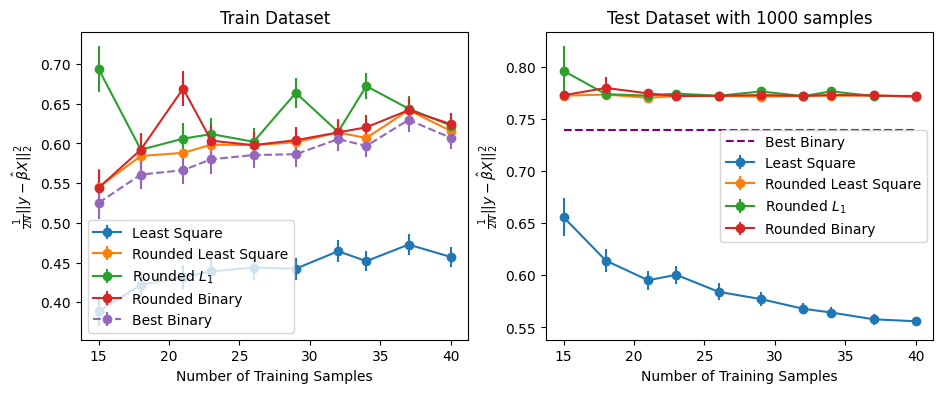

In [379]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

axs[0].errorbar(sample_size, x123_ls_train_mean_sse_per_size, yerr=np.array(x123_ls_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o',  label='Least Square')
axs[0].errorbar(sample_size, x123_rls_train_mean_sse_per_size, yerr=np.array(x123_rls_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Least Square')
axs[0].errorbar(sample_size, x123_l1_train_mean_sse_per_size, yerr=np.array(x123_l1_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded $L_1$')
axs[0].errorbar(sample_size, x123_binary_train_mean_sse_per_size, yerr=np.array(x123_binary_train_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Binary')
axs[0].errorbar(sample_size, x123_best_binary_mean_train_sse_per_size, yerr=np.array(x123_best_binary_std_train_sse_per_size)*1.96/(n_iterations**0.5),linestyle='--', marker='o', label='Best Binary')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[0].set_title('Train Dataset')
axs[0].legend()

axs[1].errorbar(sample_size, x123_ls_test_mean_sse_per_size, yerr=np.array(x123_ls_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o',  label='Least Square')
axs[1].errorbar(sample_size, x123_rls_test_mean_sse_per_size, yerr=np.array(x123_rls_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, x123_l1_test_mean_sse_per_size, yerr=np.array(x123_l1_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded $L_1$')
axs[1].errorbar(sample_size, x123_binary_test_mean_sse_per_size, yerr=np.array(x123_binary_test_std_sse_per_size)*1.96/(n_iterations**0.5), marker='o', label='Rounded Binary')
axs[1].hlines(x123_best_binary_sse_test, min(sample_size), max(sample_size), linestyle='--',color='purple', label='Best Binary')
axs[1].set_xlabel('Number of Training Samples')
axs[1].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[1].set_title('Test Dataset with 1000 samples')
axs[1].legend()


In [389]:
import itertools
# feature_mean = np.zeros(2)
# feature_cov = 2*np.eye(2)
# sigma1 = 0.5
# sigma2 = 0.5
min_error = []
for i in range(500):
    x,y = DataGenerator_x123(n_samples=10000, feature_mean=np.zeros(2), feature_cov=2*np.eye(2), sigma1=0.5, sigma2=0.5, randome_state=None)
    all_answer_lst = list(itertools.product([0, 1], repeat=3))
    error = []
    for pa in all_answer_lst:
        error.append([squared_error(np.asarray(pa), x, y), pa])
    min_error.append(min(error))

result = {}
for pa in all_answer_lst:
    result['pa_'+str(pa)] = [res for res in min_error if res[1]==pa]

for pa in all_answer_lst:
    print('number of '+str(pa)+' is:' +str(result['pa_'+str(pa)].__len__()))

number of (0, 0, 0) is:0
number of (0, 0, 1) is:0
number of (0, 1, 0) is:0
number of (0, 1, 1) is:0
number of (1, 0, 0) is:0
number of (1, 0, 1) is:0
number of (1, 1, 0) is:500
number of (1, 1, 1) is:0


In [391]:
min_error = []
for i in range(500):
    x,y = DataGenerator_x123(n_samples=10000, feature_mean=np.zeros(2), feature_cov=np.eye(2), sigma1=1, sigma2=1, randome_state=None)
    all_answer_lst = list(itertools.product([0, 1], repeat=3))
    error = []
    for pa in all_answer_lst:
        error.append([squared_error(np.asarray(pa), x, y), pa])
    min_error.append(min(error))

result = {}
for pa in all_answer_lst:
    result['pa_'+str(pa)] = [res for res in min_error if res[1]==pa]

for pa in all_answer_lst:
    print('number of '+str(pa)+' is:' +str(result['pa_'+str(pa)].__len__()))

number of (0, 0, 0) is:0
number of (0, 0, 1) is:112
number of (0, 1, 0) is:0
number of (0, 1, 1) is:142
number of (1, 0, 0) is:0
number of (1, 0, 1) is:129
number of (1, 1, 0) is:0
number of (1, 1, 1) is:117
